<a href="https://colab.research.google.com/github/Emahai/Value-Function-Approximation/blob/main/linear_vs_nonlinear_rl_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear vs Non-linear Value Function Approximation — Implementation Notebook

This notebook implements:

- **Linear approximation** (RBF features) + **Linear Q-learning with Experience Replay**
- **Non-linear approximation** (MLP) using **NFQ-style Fitted Q Iteration (FQI)**

Environments: **CartPole-v1** and **MountainCar-v0** (Gymnasium).


In [1]:
# Install dependencies
!pip install -q gymnasium numpy torch matplotlib scikit-learn


In [2]:
import random
import time
from dataclasses import dataclass
from collections import deque

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import gymnasium as gym
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.kernel_approximation import RBFSampler


In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

@dataclass
class Transition:
    s: np.ndarray
    a: int
    r: float
    sp: np.ndarray
    done: bool

class ReplayBuffer:
    def __init__(self, capacity=100_000):
        self.buf = deque(maxlen=capacity)

    def push(self, s, a, r, sp, done):
        self.buf.append(Transition(s, a, r, sp, done))

    def sample(self, batch_size):
        batch = random.sample(self.buf, batch_size)
        s = np.stack([t.s for t in batch])
        a = np.array([t.a for t in batch], dtype=np.int64)
        r = np.array([t.r for t in batch], dtype=np.float32)
        sp = np.stack([t.sp for t in batch])
        done = np.array([t.done for t in batch], dtype=np.float32)
        return s, a, r, sp, done

    def __len__(self):
        return len(self.buf)

def evaluate_policy(env, act_fn, episodes=10, seed=123):
    returns = []
    for i in range(episodes):
        obs, _ = env.reset(seed=seed+i)
        done = False
        total = 0.0
        while not done:
            a = act_fn(obs)
            obs, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            total += r
        returns.append(total)
    return float(np.mean(returns)), float(np.std(returns))


## Part A — Linear approximation (RBF features) + Linear Q-learning with Experience Replay

In [4]:
class RBFTransformer:
    """Fixed feature map phi(s) using random Fourier features for multiple RBF gammas."""
    def __init__(self, env, n_components=200, gammas=(0.5, 1.0, 2.0), seed=42, n_fit_samples=10_000):
        self.scaler = StandardScaler()
        self.featurizer = FeatureUnion([
            (f"rbf_{g}", RBFSampler(gamma=g, n_components=n_components, random_state=seed))
            for g in gammas
        ])

        obs_list = []
        obs, _ = env.reset(seed=seed)
        for _ in range(n_fit_samples):
            a = env.action_space.sample()
            obs, _, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            obs_list.append(obs)
            if done:
                obs, _ = env.reset()
        obs_mat = np.array(obs_list, dtype=np.float32)

        self.scaler.fit(obs_mat)
        scaled = self.scaler.transform(obs_mat)
        self.featurizer.fit(scaled)

        self.dim = self.transform(obs_mat[:1]).shape[1]

    def transform(self, obs_batch):
        obs_batch = np.array(obs_batch, dtype=np.float32)
        scaled = self.scaler.transform(obs_batch)
        return self.featurizer.transform(scaled).astype(np.float32)

class LinearQAgent:
    """Q(s,a) = w_a^T phi(s), separate w per action."""
    def __init__(self, n_actions, feat_dim, lr=1e-2):
        self.n_actions = n_actions
        self.W = np.zeros((n_actions, feat_dim), dtype=np.float32)
        self.lr = lr

    def act(self, phi, eps=0.1):
        if random.random() < eps:
            return random.randrange(self.n_actions)
        return int(np.argmax(self.W @ phi))

    def update_batch(self, phi_s, a, targets):
        for i in range(len(a)):
            ai = a[i]
            pred = float(self.W[ai].dot(phi_s[i]))
            err = targets[i] - pred
            self.W[ai] += self.lr * err * phi_s[i]


In [5]:
def train_linear_q_replay(
    env_id="CartPole-v1",
    total_steps=50_000,
    buffer_size=50_000,
    batch_size=128,
    gamma=0.99,
    eps_start=1.0,
    eps_end=0.05,
    eps_decay_steps=30_000,
    lr=0.05,
    seed=42,
    eval_every=5000,
):
    set_seed(seed)
    env = gym.make(env_id)
    n_actions = env.action_space.n

    rbf = RBFTransformer(env, n_components=200, gammas=(0.5, 1.0, 2.0), seed=seed)
    agent = LinearQAgent(n_actions=n_actions, feat_dim=rbf.dim, lr=lr)
    replay = ReplayBuffer(capacity=buffer_size)

    obs, _ = env.reset(seed=seed)
    ep_return = 0.0
    train_returns = []
    eval_points, eval_means = [], []

    t0 = time.time()
    for t in range(1, total_steps + 1):
        frac = min(1.0, t / eps_decay_steps)
        eps = eps_start + frac * (eps_end - eps_start)

        phi = rbf.transform([obs])[0]
        a = agent.act(phi, eps=eps)
        obs2, r, terminated, truncated, _ = env.step(a)
        done = terminated or truncated

        replay.push(obs, a, r, obs2, done)
        ep_return += r
        obs = obs2

        if done:
            train_returns.append(ep_return)
            obs, _ = env.reset()
            ep_return = 0.0

        if len(replay) >= batch_size:
            s, a_b, r_b, sp, done_b = replay.sample(batch_size)
            phi_s = rbf.transform(s)
            phi_sp = rbf.transform(sp)

            targets = np.zeros(batch_size, dtype=np.float32)
            for i in range(batch_size):
                q_next = agent.W @ phi_sp[i]
                targets[i] = r_b[i] + (1.0 - done_b[i]) * gamma * float(np.max(q_next))

            agent.update_batch(phi_s, a_b, targets)

        if eval_every and (t % eval_every == 0):
            eval_env = gym.make(env_id)
            mean_r, std_r = evaluate_policy(
                eval_env,
                act_fn=lambda o: int(np.argmax(agent.W @ rbf.transform([o])[0])),
                episodes=10,
                seed=seed + 1000,
            )
            eval_env.close()
            eval_points.append(t)
            eval_means.append(mean_r)
            print(f"[Linear+Replay] {env_id} step={t} eps={eps:.3f} eval_return={mean_r:.1f}±{std_r:.1f}")

    env.close()
    t1 = time.time()
    print(f"Training time: {t1 - t0:.2f}s")

    return agent, rbf, train_returns, eval_points, eval_means


[Linear+Replay] CartPole-v1 step=5000 eps=0.842 eval_return=107.4±39.0
[Linear+Replay] CartPole-v1 step=10000 eps=0.683 eval_return=81.5±8.0
[Linear+Replay] CartPole-v1 step=15000 eps=0.525 eval_return=119.2±17.7
[Linear+Replay] CartPole-v1 step=20000 eps=0.367 eval_return=106.1±19.6
[Linear+Replay] CartPole-v1 step=25000 eps=0.208 eval_return=315.2±139.0
[Linear+Replay] CartPole-v1 step=30000 eps=0.050 eval_return=252.1±154.9
[Linear+Replay] CartPole-v1 step=35000 eps=0.050 eval_return=108.9±23.8
[Linear+Replay] CartPole-v1 step=40000 eps=0.050 eval_return=242.0±88.2
Training time: 216.82s


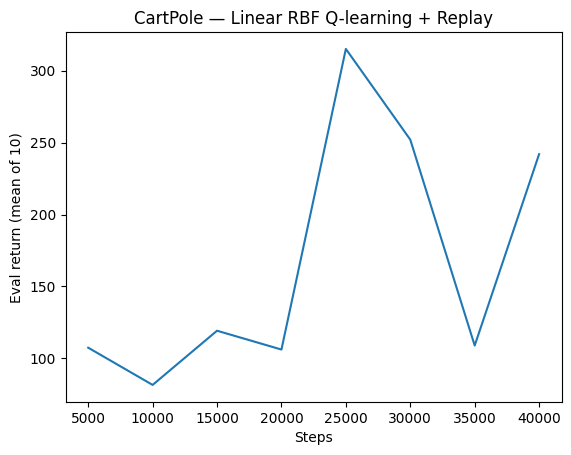

In [6]:
# Run Linear+Replay on CartPole
agent_cart, rbf_cart, cart_train_ret, cart_eval_x, cart_eval_y = train_linear_q_replay(
    env_id="CartPole-v1",
    total_steps=40_000,
    lr=0.05,
    eval_every=5000,
)

plt.figure()
plt.plot(cart_eval_x, cart_eval_y)
plt.xlabel("Steps")
plt.ylabel("Eval return (mean of 10)")
plt.title("CartPole — Linear RBF Q-learning + Replay")
plt.show()


[Linear+Replay] MountainCar-v0 step=10000 eps=0.683 eval_return=-200.0±0.0
[Linear+Replay] MountainCar-v0 step=20000 eps=0.367 eval_return=-200.0±0.0
[Linear+Replay] MountainCar-v0 step=30000 eps=0.050 eval_return=-170.7±21.2
[Linear+Replay] MountainCar-v0 step=40000 eps=0.050 eval_return=-200.0±0.0
[Linear+Replay] MountainCar-v0 step=50000 eps=0.050 eval_return=-150.3±17.1
[Linear+Replay] MountainCar-v0 step=60000 eps=0.050 eval_return=-138.4±39.1
[Linear+Replay] MountainCar-v0 step=70000 eps=0.050 eval_return=-109.0±12.7
[Linear+Replay] MountainCar-v0 step=80000 eps=0.050 eval_return=-106.9±5.5
[Linear+Replay] MountainCar-v0 step=90000 eps=0.050 eval_return=-103.7±10.5
[Linear+Replay] MountainCar-v0 step=100000 eps=0.050 eval_return=-103.1±9.5
[Linear+Replay] MountainCar-v0 step=110000 eps=0.050 eval_return=-158.2±42.0
[Linear+Replay] MountainCar-v0 step=120000 eps=0.050 eval_return=-110.0±10.5
Training time: 579.66s


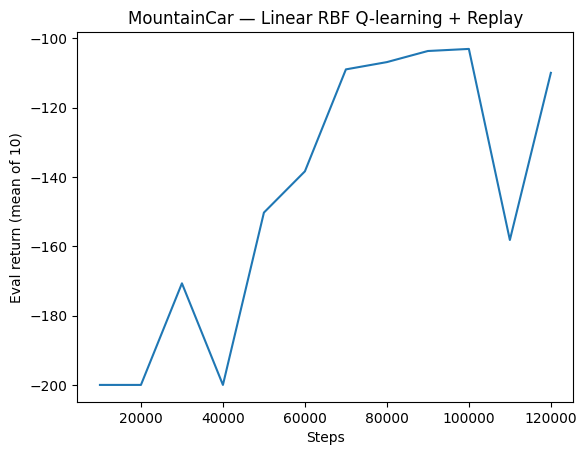

In [7]:
# Run Linear+Replay on MountainCar
agent_mc, rbf_mc, mc_train_ret, mc_eval_x, mc_eval_y = train_linear_q_replay(
    env_id="MountainCar-v0",
    total_steps=120_000,
    lr=0.02,
    eval_every=10000,
)

plt.figure()
plt.plot(mc_eval_x, mc_eval_y)
plt.xlabel("Steps")
plt.ylabel("Eval return (mean of 10)")
plt.title("MountainCar — Linear RBF Q-learning + Replay")
plt.show()


## Part B — Non-linear approximation (MLP) with NFQ-style Fitted Q Iteration (FQI)

In [8]:
class MLPQ(nn.Module):
    def __init__(self, obs_dim, n_actions, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, n_actions),
        )

    def forward(self, x):
        return self.net(x)

def collect_random_transitions(env_id, n_episodes=200, max_steps=500, seed=42):
    set_seed(seed)
    env = gym.make(env_id)
    data = []
    for ep in range(n_episodes):
        obs, _ = env.reset(seed=seed + ep)
        for _ in range(max_steps):
            a = env.action_space.sample()
            obs2, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            data.append(Transition(obs, a, r, obs2, done))
            obs = obs2
            if done:
                break
    env.close()
    return data


In [9]:
def train_nfq_fqi(
    env_id="CartPole-v1",
    n_random_episodes=200,
    fqi_iters=25,
    batch_size=256,
    gamma=0.99,
    lr=1e-3,
    hidden=128,
    seed=42,
    eval_every=5,
    device=None,
):
    set_seed(seed)
    env = gym.make(env_id)
    obs_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n
    env.close()

    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    D = collect_random_transitions(env_id, n_episodes=n_random_episodes, seed=seed)
    print(f"Collected {len(D)} transitions from {n_random_episodes} random episodes.")

    q = MLPQ(obs_dim, n_actions, hidden=hidden).to(device)
    q_target = MLPQ(obs_dim, n_actions, hidden=hidden).to(device)
    q_target.load_state_dict(q.state_dict())

    opt = optim.Adam(q.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    S = np.stack([t.s for t in D]).astype(np.float32)
    A = np.array([t.a for t in D], dtype=np.int64)
    R = np.array([t.r for t in D], dtype=np.float32)
    SP = np.stack([t.sp for t in D]).astype(np.float32)
    DONE = np.array([t.done for t in D], dtype=np.float32)

    S_t = torch.tensor(S, device=device)
    A_t = torch.tensor(A, device=device)
    R_t = torch.tensor(R, device=device)
    SP_t = torch.tensor(SP, device=device)
    DONE_t = torch.tensor(DONE, device=device)

    eval_points, eval_means = [], []

    t0 = time.time()
    for k in range(1, fqi_iters + 1):
        with torch.no_grad():
            q_next = q_target(SP_t)
            max_next = q_next.max(dim=1).values
            y = R_t + (1.0 - DONE_t) * gamma * max_next

        idx = torch.randperm(S_t.shape[0], device=device)
        total_loss = 0.0

        for start in range(0, len(idx), batch_size):
            b = idx[start:start + batch_size]
            qb = q(S_t[b])
            pred = qb.gather(1, A_t[b].unsqueeze(1)).squeeze(1)
            loss = loss_fn(pred, y[b])

            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss += loss.item()

        q_target.load_state_dict(q.state_dict())

        if eval_every and (k % eval_every == 0 or k == 1):
            eval_env = gym.make(env_id)

            def act_fn(obs):
                with torch.no_grad():
                    o = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
                    return int(torch.argmax(q(o)).item())

            mean_r, std_r = evaluate_policy(eval_env, act_fn, episodes=10, seed=seed + 999)
            eval_env.close()
            eval_points.append(k)
            eval_means.append(mean_r)
            print(f"[NFQ/FQI] {env_id} iter={k}/{fqi_iters} loss={total_loss:.3f} eval_return={mean_r:.1f}±{std_r:.1f}")

    t1 = time.time()
    print(f"Training time: {t1 - t0:.2f}s")

    return q, eval_points, eval_means


Device: cpu
Collected 4615 transitions from 200 random episodes.
[NFQ/FQI] CartPole-v1 iter=1/25 loss=7.904 eval_return=8.9±0.7
[NFQ/FQI] CartPole-v1 iter=5/25 loss=24.994 eval_return=9.6±0.7
[NFQ/FQI] CartPole-v1 iter=10/25 loss=29.224 eval_return=30.1±3.5
[NFQ/FQI] CartPole-v1 iter=15/25 loss=43.528 eval_return=69.8±20.8
[NFQ/FQI] CartPole-v1 iter=20/25 loss=50.258 eval_return=150.6±23.8
[NFQ/FQI] CartPole-v1 iter=25/25 loss=63.427 eval_return=171.0±18.9
Training time: 1.47s


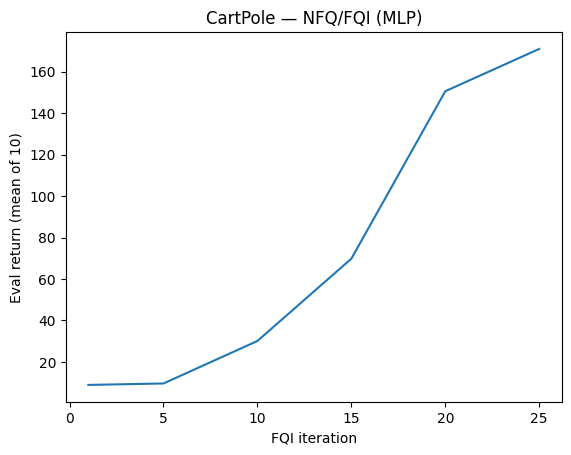

In [10]:
# Run NFQ/FQI on CartPole
q_cart, nfq_cart_x, nfq_cart_y = train_nfq_fqi(
    env_id="CartPole-v1",
    n_random_episodes=200,
    fqi_iters=25,
    lr=1e-3,
    hidden=128,
    eval_every=5,
)

plt.figure()
plt.plot(nfq_cart_x, nfq_cart_y)
plt.xlabel("FQI iteration")
plt.ylabel("Eval return (mean of 10)")
plt.title("CartPole — NFQ/FQI (MLP)")
plt.show()


Device: cpu
Collected 120000 transitions from 600 random episodes.
[NFQ/FQI] MountainCar-v0 iter=1/50 loss=6.251 eval_return=-200.0±0.0
[NFQ/FQI] MountainCar-v0 iter=5/50 loss=35.976 eval_return=-200.0±0.0
[NFQ/FQI] MountainCar-v0 iter=10/50 loss=155.187 eval_return=-200.0±0.0
[NFQ/FQI] MountainCar-v0 iter=15/50 loss=350.695 eval_return=-200.0±0.0
[NFQ/FQI] MountainCar-v0 iter=20/50 loss=592.286 eval_return=-200.0±0.0
[NFQ/FQI] MountainCar-v0 iter=25/50 loss=845.726 eval_return=-200.0±0.0
[NFQ/FQI] MountainCar-v0 iter=30/50 loss=1136.320 eval_return=-200.0±0.0
[NFQ/FQI] MountainCar-v0 iter=35/50 loss=1399.824 eval_return=-200.0±0.0
[NFQ/FQI] MountainCar-v0 iter=40/50 loss=1749.111 eval_return=-200.0±0.0
[NFQ/FQI] MountainCar-v0 iter=45/50 loss=2032.734 eval_return=-200.0±0.0
[NFQ/FQI] MountainCar-v0 iter=50/50 loss=2323.594 eval_return=-200.0±0.0
Training time: 45.59s


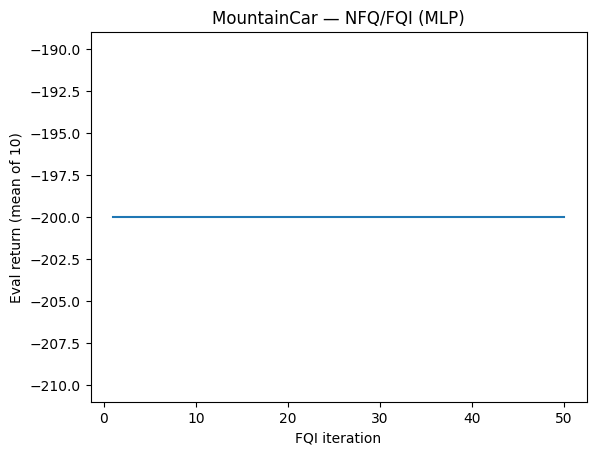

In [11]:
# Run NFQ/FQI on MountainCar
q_mc, nfq_mc_x, nfq_mc_y = train_nfq_fqi(
    env_id="MountainCar-v0",
    n_random_episodes=600,
    fqi_iters=50,
    lr=1e-3,
    hidden=128,
    eval_every=5,
)

plt.figure()
plt.plot(nfq_mc_x, nfq_mc_y)
plt.xlabel("FQI iteration")
plt.ylabel("Eval return (mean of 10)")
plt.title("MountainCar — NFQ/FQI (MLP)")
plt.show()


## Quick comparison plots


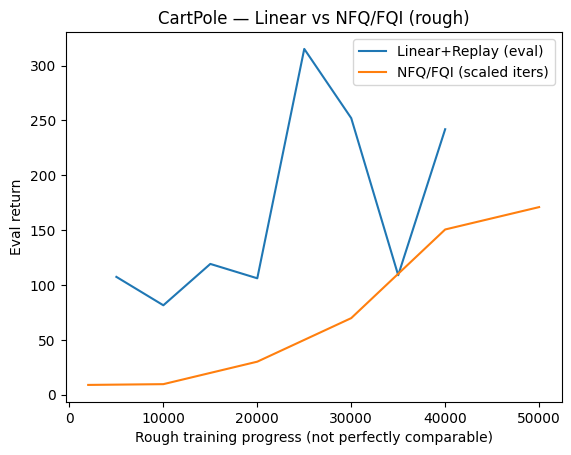

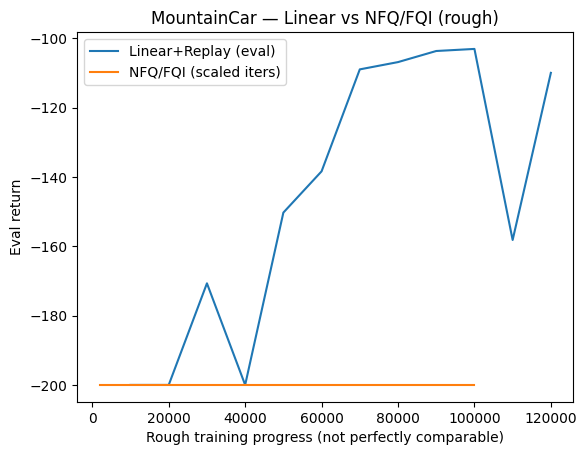

In [12]:
plt.figure()
plt.plot(cart_eval_x, cart_eval_y, label="Linear+Replay (eval)")
plt.plot([x * 2000 for x in nfq_cart_x], nfq_cart_y, label="NFQ/FQI (scaled iters)")
plt.xlabel("Rough training progress (not perfectly comparable)")
plt.ylabel("Eval return")
plt.title("CartPole — Linear vs NFQ/FQI (rough)")
plt.legend()
plt.show()

plt.figure()
plt.plot(mc_eval_x, mc_eval_y, label="Linear+Replay (eval)")
plt.plot([x * 2000 for x in nfq_mc_x], nfq_mc_y, label="NFQ/FQI (scaled iters)")
plt.xlabel("Rough training progress (not perfectly comparable)")
plt.ylabel("Eval return")
plt.title("MountainCar — Linear vs NFQ/FQI (rough)")
plt.legend()
plt.show()
